<a href="https://colab.research.google.com/github/htapia/TallerPythonIntroCienciaDatos/blob/ciia/00_Ejemplo_TiposDatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduccion a la Ciencia de Datos
Overview
Duration: 0:02:00

En estas horas vamos a desarrollar el modelo analitico conocido como regresion lineal usando datos de un experimento que vamos a realizar en el salon.

<!-- A traves de una descripcion matricial del problema de determinar los parametros optimos para una modelo lineal entre la variable objetivo y los atributos, aplicada a un problema sencillo de determinar la relacion lineal $T^2 \propto L$ entre un pendulo simple, se introducce el algoritmo del descenso por el gradiente. Despues se implementa el algoritmo usando metodos vectoriales y procurando evitar repeticiones usando `for` o metodos similares y finalmente se discute un algoritmo que puede actualizarse en tiempo casi real.  -->

## Adquisicion de datos

Vamos a tomar los datos de un experimento simple

In [0]:
import pandas as pd

In [0]:
furl='https://raw.githubusercontent.com/htapia/TallerPythonIntroCienciaDatos/ciia/notebooks/data/data.json'

In [0]:
def get_dataFile(furl):
  import urllib.request, json
  with urllib.request.urlopen(furl) as url:
    return json.loads(url.read().decode())

In [0]:
time,acceleration = get_dataFile(furl)

In [0]:
tseries = pd.Series(time)

In [0]:
df = pd.DataFrame(acceleration, columns=["ax","ay","az"])

In [0]:
df['t']=tseries

In [11]:
df.head()

,ax,ay,az,t
0,0.016822,0.395247,-0.918421,0.00
1,0.011067,0.476621,-0.879039,0.05
2,0.004252,0.538847,-0.842393,0.10
3,-0.025437,0.602143,-0.797983,0.15
4,-0.028130,0.709080,-0.704566,0.20


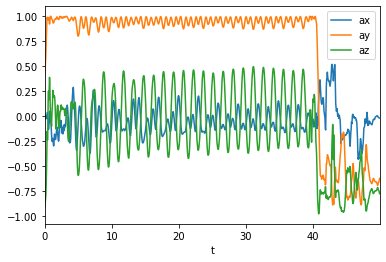

In [13]:
df.plot(x='t',y=['ax', 'ay','az'])

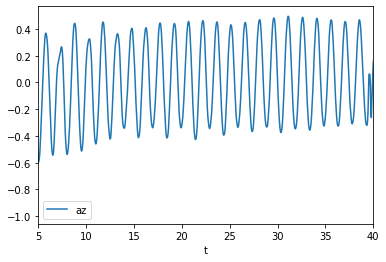

In [18]:
df.plot(x='t',y='az',xlim=[5,40])

In [22]:
df['t']<40

0       True
1       True
2       True
3       True
4       True
       ...  
995    False
996    False
997    False
998    False
999    False
Name: t, Length: 1000, dtype: bool

In [0]:
rdi=df.loc[df["t"] < 40, ["t","az"]]

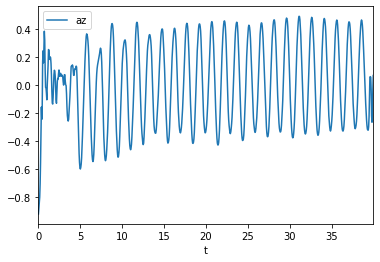

In [29]:
rdi.plot(x='t',y='az')

In [0]:
rdi = df.loc[(df['t'] > 5) & (df['t'] < 40), ['t','az']] #'ax':'t']


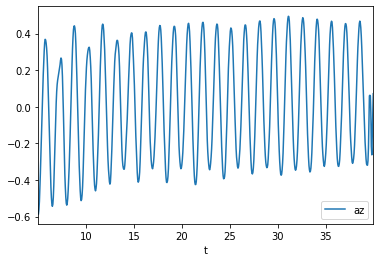

In [45]:
rdi.plot(x='t',y='az')

In [0]:
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
import numpy as np


In [0]:
rdi.values[:,1]

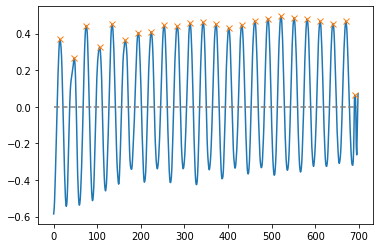

In [60]:
z = rdi.values[:,1]
peaks, _ = find_peaks(z, height=0)
plt.plot(z)
plt.plot(peaks, z[peaks], "x")
plt.plot(np.zeros_like(z), "--", color="gray")
plt.show()

In [0]:
t = rdi.values[:,0][peaks]

In [55]:
periodos = np.diff(t)
print(periodos)

[1.65 1.4  1.55 1.4  1.5  1.5  1.5  1.45 1.5  1.5  1.5  1.45 1.45 1.5
 1.55 1.45 1.5  1.5  1.5  1.5  1.45 1.5  1.05]


In [101]:
print(1/periodos)

[0.60606061 0.71428571 0.64516129 0.71428571 0.66666667 0.66666667
 0.66666667 0.68965517 0.66666667 0.66666667 0.66666667 0.68965517
 0.68965517 0.66666667 0.64516129 0.68965517 0.66666667 0.66666667
 0.66666667 0.66666667 0.68965517 0.66666667 0.95238095]


### Para los valientes

In [0]:
import numpy.fft as fft

In [0]:
# Time domain signal

N = z.size

In [0]:
Fs = 50000 # 50 milisecs
# DFT
X = np.fft.fft(z)
X_db = 20*np.log10(2*np.abs(X)/N)
#f = np.fft.fftfreq(N, 1/Fs)
f = np.arange(0, N)*Fs/N

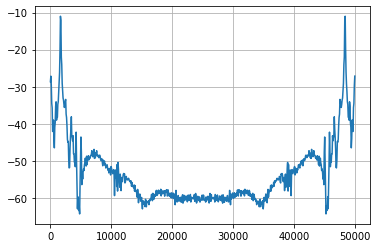

In [81]:
plt.plot(f, X_db)
plt.grid()
plt.show()

In [82]:
X_db.max()

-10.99769122773469

In [83]:
f[X_db.argmax()]

1645.2074391988556

In [85]:
f[X_db.argmax()]/1000.

1.6452074391988556

In [86]:
temporal_window = t[-1]-t[0] #seconds
temporal_window

33.85

In [0]:
N = len(z) #datapoints
T = 60./(temporal_window/N) #Sample rate average (readings/sec)

In [97]:
a=np.abs(fft.rfft(z, n=z.size))
a[0]=0 #Not sure if this is a good idea but seems to help with choppy data..
freqs = fft.rfftfreq(z.size, d=1./T)
freqs = np.divide(60,freqs)

max_freq = freqs[np.argmax(a)]
print("Peak found at %s second period (%s minutes)" % (max_freq, max_freq/60))

Peak found at 1.4717391304347827 second period (0.024528985507246377 minutes)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


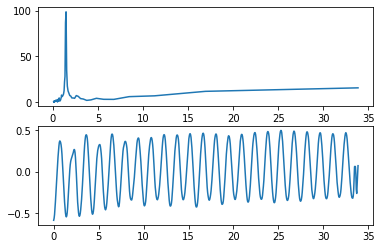

In [99]:
plt.subplot(211)
plt.plot(freqs,a)
plt.subplot(212)
plt.plot(np.linspace(0,temporal_window,z.size),z)
plt.show()

## Regresion Lineal

Para presentar la idea de regresion lineal se usaran los datos siguientes:

In [109]:
pd.__version__

'0.25.3'

In [0]:
import io

In [0]:
io.StringIO

In [0]:
data="""26.4, 1.09, 1.13, 1.08, 1.06, 1.09, 1.09, 0.04 \n 
35.4, 1.33, 1.27, 1.32, 1.25, 1.22, 1.28, 0.05 \n
38.7, 1.33, 1.36, 1.41, 1.33, 1.25, 1.34, 0.08 \n
46.6, 1.46, 1.40, 1.34, 1.45, 1.29, 1.39, 0.10 \n
52.2, 1.64, 1.57, 1.56, 1.55, 1.60, 1.58, 0.05 \n
57.3, 1.55, 1.50, 1.68, 1.55, 1.58, 1.57, 0.10 \n
63.2, 1.64, 1.64, 1.70, 1.82, 1.74, 1.71, 0.11 \n
72.4, 1.85, 1.78, 1.82, 1.80, 1.82, 1.81, 0.04 \n
86.5, 1.92, 1.92, 1.94, 1.95, 1.95, 1.94, 0.02"""

In [112]:
df = pd.read_csv(io.StringIO(data), names=["L", "T1", "T2", "T3", "T4", "T5", "ave", "unc"])
df

,L,T1,T2,T3,T4,T5,ave,unc
0,26.4,1.09,1.13,1.08,1.06,1.09,1.09,0.04
1,35.4,1.33,1.27,1.32,1.25,1.22,1.28,0.05
2,38.7,1.33,1.36,1.41,1.33,1.25,1.34,0.08
3,46.6,1.46,1.40,1.34,1.45,1.29,1.39,0.10
4,52.2,1.64,1.57,1.56,1.55,1.60,1.58,0.05
5,57.3,1.55,1.50,1.68,1.55,1.58,1.57,0.10
6,63.2,1.64,1.64,1.70,1.82,1.74,1.71,0.11
7,72.4,1.85,1.78,1.82,1.80,1.82,1.81,0.04
8,86.5,1.92,1.92,1.94,1.95,1.95,1.94,0.02


In [0]:
df.to_csv('pendulo_exp.csv')

In [0]:
from google.colab import files
files.download('pendulo_exp.csv') 

In [0]:
expURL="https://raw.githubusercontent.com/htapia/TallerPythonIntroCienciaDatos/ciia/notebooks/data/pendulo_exp.csv"
df = pd.read_csv(expURL)

In [120]:
df

,Unnamed: 0,L,T1,T2,T3,T4,T5,ave,unc
0,0,26.4,1.09,1.13,1.08,1.06,1.09,1.09,0.04
1,1,35.4,1.33,1.27,1.32,1.25,1.22,1.28,0.05
2,2,38.7,1.33,1.36,1.41,1.33,1.25,1.34,0.08
3,3,46.6,1.46,1.40,1.34,1.45,1.29,1.39,0.10
4,4,52.2,1.64,1.57,1.56,1.55,1.60,1.58,0.05
5,5,57.3,1.55,1.50,1.68,1.55,1.58,1.57,0.10
6,6,63.2,1.64,1.64,1.70,1.82,1.74,1.71,0.11
7,7,72.4,1.85,1.78,1.82,1.80,1.82,1.81,0.04
8,8,86.5,1.92,1.92,1.94,1.95,1.95,1.94,0.02


In [0]:

df = df.drop(df.columns[0], axis=1)

Usaremos unicamente las dos primeras columnas de los datos para estudiar la regresion lineal 

In [0]:
x = df["L"]
x

0    26.4
1    35.4
2    38.7
3    46.6
4    52.2
5    57.3
6    63.2
7    72.4
8    86.5
Name: L, dtype: float64

Como primer ejercicio vamos a usar la implementacion de regresion lineal que esta en la libreria `scikit` para lo cual es necesario que los datos tengan una estructura particular, de modo que vamos a covnertir las columndas de datos a esa forma matricial con `numpy`

In [0]:
import numpy as np

La variable independiente, caracteristica o atributo es la longitud del pendulo

In [0]:
x = np.array(x).reshape(-1,1)
print(x)

[[26.4]
 [35.4]
 [38.7]
 [46.6]
 [52.2]
 [57.3]
 [63.2]
 [72.4]
 [86.5]]


In [0]:
y = np.array(df["T1"]).reshape(-1,1)
y *= y

In [0]:
import matplotlib.pyplot as plt

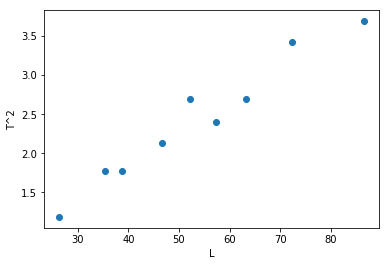

In [0]:
plt.scatter(x, y)
plt.xlabel("L")
plt.ylabel("T^2")

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
lr = LinearRegression()

In [0]:
regr = lr.fit(x, y)

In [0]:
y_pred = lr.predict(x)

In [0]:
slope = regr.coef_[0][0]

In [0]:
b = regr.intercept_[0]

In [0]:
print(slope, b)

(0.04150929422306598, 0.20862231726870162)


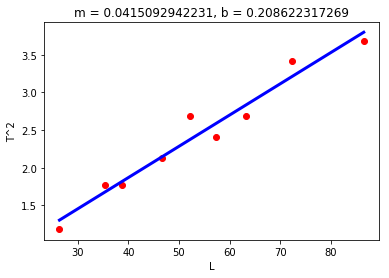

In [0]:
plt.scatter(x, y, color='red')
plt.plot(x, y_pred, color='blue', linewidth=3)

plt.xlabel("L")
plt.ylabel("T^2")

plt.title("m = {}, b = {}".format(m, b))

Vamos a construir explicitamente la recta anterior sin recurrir a ninguna librearia o funcion, unicamente usando algebra lineal.

In [0]:
n = x.shape[0] # numero de instancias, mediciones, renglones de los datos
m = x.shape[1] # numero de columnas, variables o atributos de los datos

**Nota importante** m, el numero de columnas variable independientes, o atributos determina la dimension del problema. La dimension determina el numero de coeficientes que se tienen que determinar en el problema.

In [0]:
np.ones(n)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [0]:
np.ones(n).reshape(-1,1)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [0]:
X = np.append(np.ones(n).reshape(-1,1), x, axis=1)
X

array([[ 1. , 26.4],
       [ 1. , 35.4],
       [ 1. , 38.7],
       [ 1. , 46.6],
       [ 1. , 52.2],
       [ 1. , 57.3],
       [ 1. , 63.2],
       [ 1. , 72.4],
       [ 1. , 86.5]])

In [0]:
X.shape

(9, 2)

In [0]:
Xt = X.transpose()
Xt.shape

(2, 9)

In [0]:
X.dot(Xt)

array([[ 697.96,  935.56, 1022.68, 1231.24, 1379.08, 1513.72, 1669.48,
        1912.36, 2284.6 ],
       [ 935.56, 1254.16, 1370.98, 1650.64, 1848.88, 2029.42, 2238.28,
        2563.96, 3063.1 ],
       [1022.68, 1370.98, 1498.69, 1804.42, 2021.14, 2218.51, 2446.84,
        2802.88, 3348.55],
       [1231.24, 1650.64, 1804.42, 2172.56, 2433.52, 2671.18, 2946.12,
        3374.84, 4031.9 ],
       [1379.08, 1848.88, 2021.14, 2433.52, 2725.84, 2992.06, 3300.04,
        3780.28, 4516.3 ],
       [1513.72, 2029.42, 2218.51, 2671.18, 2992.06, 3284.29, 3622.36,
        4149.52, 4957.45],
       [1669.48, 2238.28, 2446.84, 2946.12, 3300.04, 3622.36, 3995.24,
        4576.68, 5467.8 ],
       [1912.36, 2563.96, 2802.88, 3374.84, 3780.28, 4149.52, 4576.68,
        5242.76, 6263.6 ],
       [2284.6 , 3063.1 , 3348.55, 4031.9 , 4516.3 , 4957.45, 5467.8 ,
        6263.6 , 7483.25]])

In [0]:
M = Xt.dot(X)

In [0]:
detM = np.linalg.det(M)
1./detM

3.852368012093361e-05

Como el determinante de $M$ es no nulo, puedo construir la inversa $M^{-1}$

In [0]:
Minv = np.linalg.inv(M)

In [0]:
M.dot(Minv)

array([[ 1.00000000e+00, -2.77555756e-17],
       [ 0.00000000e+00,  1.00000000e+00]])

In [0]:
Minv.dot(M)

array([[ 1.00000000e+00, -1.13686838e-13],
       [ 0.00000000e+00,  1.00000000e+00]])

In [0]:
Minv.shape

(2, 2)

In [0]:
Xt.shape

(2, 9)

In [0]:
y.shape

(9, 1)

In [0]:
Minv.dot(Xt)

array([[ 6.05132664e-01,  4.39161093e-01,  3.78304850e-01,
         2.32618693e-01,  1.29347494e-01,  3.52969367e-02,
        -7.35066488e-02, -2.43166477e-01, -5.03188605e-01],
       [-9.28805928e-03, -6.16764119e-03, -5.02348789e-03,
        -2.28445423e-03, -3.42860753e-04,  1.42537616e-03,
         3.47098358e-03,  6.66074429e-03,  1.15493993e-02]])

In [0]:
Minv.dot(Xt).dot(y)

array([[0.20862232],
       [0.04150929]])

In [0]:
print(slope,b)

(0.04150929422306598, 0.20862231726870162)


In [0]:
def linh(x, theta):
    return theta[0]*x[0]+theta[1]*x[1]


In [0]:
theta = np.array([1,1])

In [0]:
X

array([[ 1. , 26.4],
       [ 1. , 35.4],
       [ 1. , 38.7],
       [ 1. , 46.6],
       [ 1. , 52.2],
       [ 1. , 57.3],
       [ 1. , 63.2],
       [ 1. , 72.4],
       [ 1. , 86.5]])

In [0]:
linh(X[0],theta)

27.4

In [0]:
hipLineal=[linh(instancias,theta) for instancias in X]

In [0]:
# el error en cada instancia al usar la hipotesis lineal
hipLineal - y[::,0]

array([26.2119, 34.6311, 37.9311, 45.4684, 50.5104, 55.8975, 61.5104,
       69.9775, 83.8136])

In [0]:
# definir una funcion que evalue el error
def error(X, y, theta):
    '''
    Utiliza la funcion linh y list comprehension para 
    evaluar el error sobre X para una lista de parametros theta
    '''
    hipl = [linh(instancias,theta) for instancias in X]
    return hipl - y[::,0]

In [0]:
error(X, y, theta)

array([26.2119, 34.6311, 37.9311, 45.4684, 50.5104, 55.8975, 61.5104,
       69.9775, 83.8136])

In [0]:
theta = np.random.randn(2)

In [0]:
# error al suponer la hipotesis en cada instancia de X
e = error(X, y, [1,1])

In [0]:
#termino de la derivada respecto a theta0
djd0=e*X[::,0]

In [0]:
djd0.sum()

465.9519

In [0]:
# termino de la derivada respecto a theta1
djd1 = e*X[::,1]
djd1.sum()

27547.970419999998

In [0]:
alpha = 0.01

In [0]:
theta 

array([0.19500787, 1.9736822 ])

In [0]:
dJ = np.array([djd0.sum(), djd1.sum()])

In [0]:
theta - alpha*dJ

array([  -4.46451113, -273.506022  ])

In [0]:
theta = np.ones(2)

In [0]:
print(theta)
e = error(X, y, theta) # actualiza el error
djd0 = e*X[::,0]
djd1 = e*X[::,1]
dJ = np.array([djd0.sum(), djd1.sum()])
theta = theta - alpha*dJ
print(theta)

[6.66325868e+17 3.94545570e+19]
[-1.88262608e+20 -1.11474252e+22]


# Tarea

implementar el algoritmo anterior de modo que en cada iteracion, que se llama una epoca o una generacion del algoritmo, se calcule el error y se use como criterio de convergencia

El resultado debe ser el mismo a el encontrado anteriormente, es decir:

In [0]:
slope

0.04150929422306598

In [0]:
b

0.20862231726870162